In [79]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import random
import pysam
import glob
import re
#import genomeview
from pybedtools import BedTool
import mappy as mp
from plotting_utils import figure_path
from matplotlib import rcParams
from peak_utils import *
from tblout_parser import read_tbl

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
peak_path = project_path + '/bed_files/merged_bed/MACS2/annotated'
#peak_path = project_path + '/CLAM//BED_files/peaks/annotation'
peak_tsv = peak_path + '/unfragmented.filtered.tsv'
print(peak_tsv)
peak_df = load_peaks(peak_tsv)  \
    .assign(sense_gtype = lambda d: np.where(d.sense_gtype == ".", 'Unannotated', d.sense_gtype))\
    .assign(antisense_gtype = lambda d: np.where(d.antisense_gtype == ".", 'Unannotated', d.antisense_gtype)) \
    .sort_values('pileup', ascending=False)
peak_df.head()

/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.filtered.tsv


,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
46591,chr16,223472,223709,unfragmented.filtered.rvs_peak_9804,23035,595.31952,2310.88525,2303.52808,776.0,15,.,Unannotated,-,LSM11,RBP,0.0,0.0,Antisense
46592,chr16,230338,230554,unfragmented.filtered.rvs_peak_9807,19109,481.10477,1918.24207,1910.96362,693.0,12,.,Unannotated,-,NCBP2,RBP,0.0,0.0,Antisense
46593,chr16,227336,227447,unfragmented.filtered.rvs_peak_9806,18485,478.47345,1855.70898,1848.58752,660.0,12,.,Unannotated,-,YBX3,RBP,0.0,0.0,Antisense
0,chr11,65273309,65273587,unfragmented.filtered.fwd_peak_5286,21335,510.76828,2140.59448,2133.57373,517.0,15,GTF2F1,RBP,+,TALAM1,Long RNA,0.0,0.0,Sense
1,chr16,24228399,24228506,unfragmented.filtered.fwd_peak_10924,16464,415.74338,1653.24133,1646.40771,423.0,14,GA-rich,Repeats,+,.,Unannotated,0.0,0.0,Sense


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


Plotted:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_qc.pdf


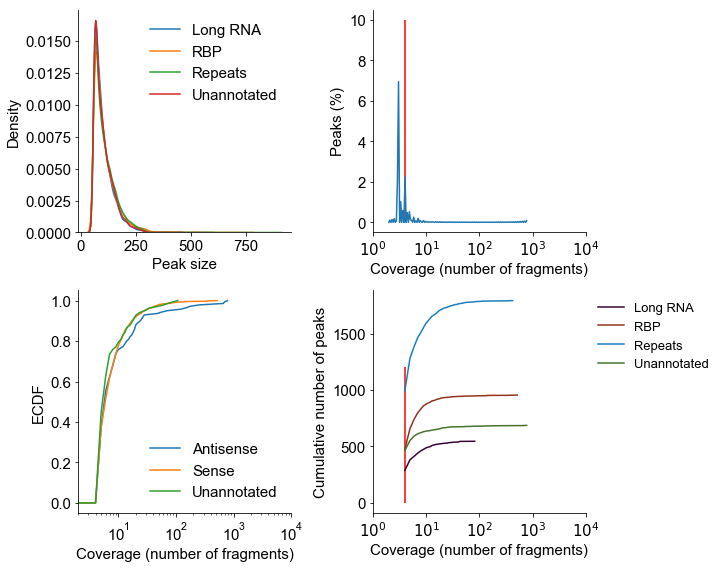

In [81]:
fig = plt.figure(figsize=(10,8))
size_ax = fig.add_subplot(221)
cov_ax = fig.add_subplot(222)
number_ax = fig.add_subplot(224)
dist_cov_ax = fig.add_subplot(223)
#peak_annotation_ax = fig.add_subplot(224)

plot_peak_size(peak_df, ax = size_ax)
size_ax.legend(fontsize=15, frameon=False)
plot_peak_coverage(peak_df, cov_ax, log=True)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax, ce)
#### add hepG2
#combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
#                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
#plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [82]:
peak_df.sense_gtype.unique()

array(['Unannotated', 'RBP', 'Repeats', 'Long RNA'], dtype=object)

Saved: /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_figure.pdf


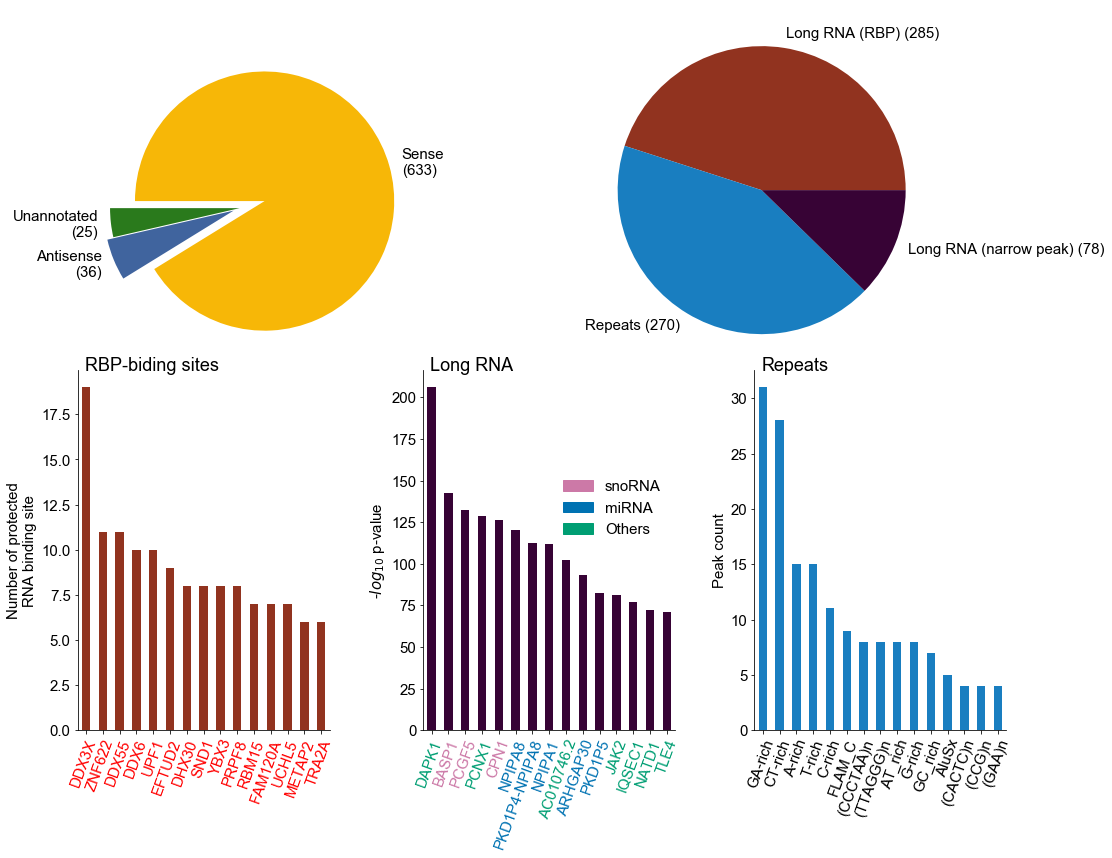

In [83]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.5, 0.45, 0.45])
pie_ax = fig.add_axes([0.6, 0.5, 0.5, 0.5])
rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
plot_repeats_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(peak_df, long_ax, ce, top_n = top_n, y_val = 'log10p')
fig.text(-0.09,0.5, 'RBP-biding sites', fontsize=18)
fig.text(0.39,0.5, 'Long RNA', fontsize=18)
fig.text(0.85,0.5, 'Repeats', fontsize=18)

figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [84]:
peak_df \
    .query('')

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
46591,chr16,223472,223709,unfragmented.filtered.rvs_peak_9804,23035,595.31952,2310.88525,2303.52808,776.0,15,.,Unannotated,-,LSM11,RBP,0.000000e+00,0.000000e+00,Antisense
46592,chr16,230338,230554,unfragmented.filtered.rvs_peak_9807,19109,481.10477,1918.24207,1910.96362,693.0,12,.,Unannotated,-,NCBP2,RBP,0.000000e+00,0.000000e+00,Antisense
46593,chr16,227336,227447,unfragmented.filtered.rvs_peak_9806,18485,478.47345,1855.70898,1848.58752,660.0,12,.,Unannotated,-,YBX3,RBP,0.000000e+00,0.000000e+00,Antisense
0,chr11,65273309,65273587,unfragmented.filtered.fwd_peak_5286,21335,510.76828,2140.59448,2133.57373,517.0,15,GTF2F1,RBP,+,TALAM1,Long RNA,0.000000e+00,0.000000e+00,Sense
1,chr16,24228399,24228506,unfragmented.filtered.fwd_peak_10924,16464,415.74338,1653.24133,1646.40771,423.0,14,GA-rich,Repeats,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense
2,chr19,11333579,11333670,unfragmented.filtered.rvs_peak_13183,14270,378.45038,1433.87048,1427.00208,389.0,15,EFTUD2,RBP,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense
3,chr16,67844880,67845028,unfragmented.filtered.rvs_peak_10566,14083,353.60434,1415.16394,1408.36792,358.0,15,FLAM_C,Repeats,-,TSNAXIP1,Long RNA,0.000000e+00,0.000000e+00,Sense
4,chr4,140222882,140222997,unfragmented.filtered.fwd_peak_22727,9125,271.14563,919.21747,912.58722,341.0,14,FXR2,RBP,+,NDUFC1,Long RNA,0.000000e+00,0.000000e+00,Sense
5,chr18,50612521,50612756,unfragmented.filtered.fwd_peak_13578,9051,269.83783,911.73035,905.11072,337.0,15,(TTC)n,Repeats,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense
46594,chr16,230708,230855,unfragmented.filtered.rvs_peak_9808,7638,233.14352,770.38989,763.87238,252.0,12,.,Unannotated,-,YBX3,RBP,0.000000e+00,0.000000e+00,Antisense


In [66]:
peaks = peak_df
lp = peaks[peaks.sense_gtype.str.contains('Long RNA')] \
        .groupby('sense_gname', as_index=False)\
        .apply(pick_lp) \
        .nlargest(15, 'log10p') \
        .assign(peak_size = lambda d: d.end - d.start )
lp

,,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,peak_size
1361,24,chr9,90294212,90294292,unfragmented.filtered.fwd_peak_30278,2000,75.14536,206.04535,200.04652,82.0,11,DAPK1,Long RNA,+,.,Unannotated,9.008448e-207,1.698366e-203,Sense,80
622,36,chr5,17249702,17249764,unfragmented.filtered.fwd_peak_23317,1369,45.35780,142.79984,136.96942,45.0,8,BASP1,Long RNA,+,.,Unannotated,1.585477e-143,2.013071e-140,Sense,62
3290,42,chr10,92933895,92933969,unfragmented.filtered.fwd_peak_3945,1265,42.39968,132.29344,126.51202,42.0,10,PCGF5,Long RNA,+,.,Unannotated,5.088151e-133,5.755624e-130,Sense,74
3292,43,chr14,71389030,71389208,unfragmented.filtered.fwd_peak_8975,1230,41.41365,128.81099,123.04235,41.0,7,PCNX1,Long RNA,+,.,Unannotated,1.545290e-129,1.716790e-126,Sense,178
1149,44,chr10,101817588,101817660,unfragmented.filtered.rvs_peak_3734,1206,40.45930,126.36660,120.64291,40.0,13,CPN1,Long RNA,-,.,Unannotated,4.299322e-127,4.692673e-124,Sense,72
3877,47,chr16,18430617,18430707,unfragmented.filtered.rvs_peak_10104,1144,42.63100,120.14444,114.44382,43.0,14,RP11-1212A22.1,Long RNA,-,.,Unannotated,7.170674e-121,7.313500e-118,Sense,90
4483,50,chr16,16468913,16469003,unfragmented.filtered.fwd_peak_10808,1066,40.58591,112.39415,106.69270,41.0,12,RP11-958N24.2,Long RNA,+,.,Unannotated,4.035060e-113,3.922520e-110,Sense,90
4482,51,chr16,15027133,15027223,unfragmented.filtered.fwd_peak_10790,1062,41.25878,111.90961,106.21075,42.0,13,RP11-958N24.1,Long RNA,+,.,Unannotated,1.231374e-112,1.178614e-109,Sense,90
116,56,chr2,198145797,198145889,unfragmented.filtered.rvs_peak_15940,965,33.55161,102.19388,96.55914,33.0,3,AC010746.2,Long RNA,-,.,Unannotated,6.399116e-103,5.607338e-100,Sense,92
513,65,chr1,161022152,161022229,unfragmented.filtered.rvs_peak_1777,879,31.51741,93.50586,87.91005,31.0,13,ARHGAP30,Long RNA,-,.,Unannotated,3.119895e-94,2.426303e-91,Sense,77


# Intron #

In [74]:
columns = peak_df.columns
columns = np.append(columns,['intron_chrom','intron_start','intron_end',
               'intron_gene','intron_score','intron_strand'])
full_peak = pd.read_table(peak_path + '/unfragmented.unfiltered.tsv')
intron_df = BedTool()\
    .from_dataframe(full_peak)\
    .intersect('/stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed', 
               f= 0.8,F=0.8,wb=True)\
    .to_dataframe(names = columns)
intron_df.shape

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-



(117, 24)

In [78]:
intron_df \
    .query('pileup >= 5 & sample_count >= 5' )\
    .filter(['chrom','start','end','peakname','sense_gname'])\
    .drop_duplicates()\
    .reset_index(drop=True) \
    .assign(size = lambda d: d.end - d.start)

,chrom,start,end,peakname,sense_gname,size
0,chr19,11333582,11333668,unfragmented.unfiltered.rvs_peak_13246,EFTUD2,86
1,chr22,50356514,50356587,unfragmented.unfiltered.fwd_peak_19911,MIR6821,73
2,chr17,39913789,39913885,unfragmented.unfiltered.rvs_peak_11575,XPO5,96
3,chr16,18430618,18430707,unfragmented.unfiltered.rvs_peak_10144,RP11-1212A22.1,89
4,chr16,15027134,15027223,unfragmented.unfiltered.fwd_peak_10945,RP11-958N24.1,89
5,chr16,2149772,2149861,unfragmented.unfiltered.rvs_peak_9922,EFTUD2,89
6,chr15,91423005,91423096,unfragmented.unfiltered.fwd_peak_10518,XPO5,91
7,chr16,18470720,18470809,unfragmented.unfiltered.rvs_peak_10146,RP11-1212A22.4,89
8,chr16,16425621,16425710,unfragmented.unfiltered.fwd_peak_10961,PKD1P1,89
9,chr17,73500562,73500652,unfragmented.unfiltered.rvs_peak_12022,CASKIN2,90


In [ ]:
ss_dinucleotide = defaultdict(int)
ss_dinucleotide_seq = defaultdict(list)
seqs = []       

intron_df = intron_df.query('pileup >=3') \
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(dinucleotide = lambda d: d.seq.str.slice(0,2) + ':' + (d.seq + 'N').str.slice(-3,-1))
intron_df.head()

In [ ]:
tablename = figure_path + '/intron_table.csv'
intron_df \
    .filter(regex='chrom|start|end|log10|pileup|intron_gene|seq') \
    .sort_values('pileup', ascending=False)\
    .to_csv(tablename, index=False)
print('Written: ', tablename)

In [ ]:
intron_df.query('pileup >= %i' %pileup_cutoff) \
    .assign(length = lambda d: d.end - d.start) \
    .describe()

In [ ]:
sns.jointplot(peak_df.pileup.transform(np.log),
            peak_df.sample_count)

In [ ]:
','.join(rbp_df.head(15).index)

In [ ]:
peak_df\
    .query('pileup >= %i' %pileup_cutoff)\
    .to_csv(peak_path + '/peaks.tsv',sep='\t', index=False)

In [ ]:
ax = plt.subplot()
pdf = peak_df\
    .pipe(lambda d: d[~d.sense_gtype.str.contains('tRF')])\
    .query('pileup >= %i' %pileup_cutoff)\
    .assign(peak_width = lambda d: d.end-d.start)\
    .assign(log_pile = lambda d: d.pileup.transform(np.log10))

pdf.plot.scatter('peak_width','pileup', 
                  color = ce.transform(pdf.sense_gtype), ax = ax,
                 alpha = 0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ce.show_legend(ax = ax, bbox_to_anchor =(1,1), frameon=False)
sns.despine()

In [ ]:
ax = plt.subplot()

for gt, gd in peak_df\
            .query('pileup >= %i' %(pileup_cutoff))\
            .assign(peak_width = lambda d: (d.end-d.start))\
            .groupby('sense_gtype'):
    alpha = 1 if gt in ["Long RNA"] else 1
    sns.distplot(gd.peak_width, ax = ax, kde_kws={'alpha':alpha},
                label = gt, color = ce.encoder[gt],
                hist=False)
lgd = ax.legend(frameon=False)
for lh in lgd.legendHandles: 
    lh.set_alpha(1)
ax.set_ylabel('Density')
ax.set_xlabel('Peak width ($log_{10}$ nt)')

x_range = np.arange(1,500, 50)
ax.set_xlim(x_range.min(), x_range.max())
ax.set_xticks(x_range)
for xt, x in zip(ax.get_xticklabels(), x_range):
    xt.set_text(r'$10^{%s}$' %(x))

In [ ]:
lR_peak = peak_df[peak_df.sense_gtype.str.contains('Long RNA')] \
    .sort_values('log10p', ascending=False) 
lR_peak.head(20)

In [ ]:
%load_ext autoreload
%autoreload 2
import mygene as mg
import gseapy as gsp
mgi = mg.MyGeneInfo()

glist = intron_df.query('pileup >= %i' %pileup_cutoff) \
    .filter(['pileup','gid']) \
    .assign(ensg = lambda d: d.gid.str.extract('(ENSG[0-9]+)')) \
    .assign(symbol = lambda d: list(map(lambda x: x['symbol'], mgi.getgenes(d.ensg))))

In [ ]:
glist

In [ ]:
%tb
rnk = glist\
    .filter(['symbol','pileup']) \
    .pipe(lambda d: d[~d.symbol.str.contains('^AC')])\
    .rename(columns={'symbol':'gene_name'})
#res = gsp.prerank(rnk = rnk, gene_sets='/stor/work/Lambowitz/ref/gene_sets/c2.all.v6.2.symbols.gmt')
print('\n'.join(rnk.gene_name.tolist()))



In [ ]:
peaks\
    .query('merged_type == "miRNA"')\
    .filter(regex='log10p|picked_RNA_sense')\
    .set_index('picked_RNA_sense')\
    .nlargest(10, 'log10p')\
    .plot.bar() 

In [ ]:
peaks.pipe(lambda d: d[d.picked_RNA_sense.str.contains("CGGA")])

In [ ]:
peaks\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .query('merged_type == "Repeats" | (anti_merged_type == "Repeats" & is_sense != "Sense")')

In [ ]:
peaks\
    .query('merged_type=="RBP"')\
    .pipe(lambda d: d[~d.gtype.str.contains(lrna_regex)])

In [ ]:
import gseapy as gsp

In [ ]:
res = gsp.prerank(rnk = rbp_df.sort_values(0,ascending=False),
           gene_sets = 'KEGG_2016')

In [85]:
    rbp_count = defaultdict(int)
    for i, row in peaks.query('pileup >= %i & sample_count >= %i' %(pileup_cutoff, sample_cutoff)).iterrows():
        added = set()
        for btype, bp in zip(row['sense_gtype'].split(','),
                        row['sense_gname'].split(',')):
            if btype == "RBP":
                if bp not in added:
                    rbp_count[bp] += 1
                    added.add(bp)

    rbp_df = pd.DataFrame\
        .from_dict(rbp_count, orient='index')\
        .sort_values(0, ascending=False)

In [90]:
','.join(rbp_df.head(15).index)

'DDX3X,ZNF622,DDX55,DDX6,UPF1,EFTUD2,DHX30,SND1,YBX3,PRPF8,RBM15,FAM120A,UCHL5,METAP2,TRA2A'